In [2]:
import numpy as np
import pandas as pd
import cvxopt 
import cvxpy as cp
import scipy as scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pygsp import graphs

In [38]:
def GDO(delta, k):
    if k == 1:
        return delta
    elif k%2 == 0:
        return np.dot(np.transpose(delta), GDO(delta, k-1))
    elif k%2 == 1:
        return np.dot(delta, GDO(delta, k-1))

  
    
def count_one(x):
    tmp = 0
    for i in range(len(x)):
        for j in range(len(x)):
            
            if x[i][j] == 1:
                tmp +=1
    return tmp

def in_list(x, L):
    
    tmp2 = False
    for y in L:
        tmp1 = True
        
        for i in range(len(x)):
            #avoid repetition 
            tmp1 = (tmp1 and np.abs(x[i]) == np.abs(y[i])) 
            
            
        tmp2 = (tmp2 or tmp1)
    return tmp2
        
                
def inc_to_delta(inc):
    
    n = len(inc)
    
  
    k = 0
    size = int(count_one(inc)/2)
    tmp = [np.zeros(n).tolist() for i in range(size)]

   
    
    for i in range(n):
        for j in range(i,n):
           
            if inc[i][j] == 1:
                tmp[k][i] = -1
                tmp[k][j] = 1
                k+=1
                
            
    
    return tmp

def get_grid_graph(n_nodes_height=10, n_nodes_width=10) -> graphs.Graph:
    """Return a 2D grid graph."""
    g = graphs.Grid2d(n_nodes_height, n_nodes_width)
    xx, yy = np.meshgrid(np.arange(n_nodes_height), np.arange(n_nodes_width))
    coords = np.array((xx.ravel(), yy.ravel())).T
    
    g.set_coordinates(coords)
    g.compute_laplacian("combinatorial")
    return g, coords

def loss_function(y,beta):
    J = (cp.pnorm(y - beta, p=2))**2
    S = 0
    C = np.linalg.norm(y-beta,2)
    for i in range (0,len(y)) :
        S += (y[i]-beta[i])**2
    return(S/len(y))

def generalized_inverse(mat):
    return np.linalg.inv(np.transpose(mat) @ mat) @ np.transpose(mat)

def lambda_max(y,delta, k):
    Dk = GDO(delta, k)
   
    lmda_max= 0.0
   
    
    if k%2 == 0:
       
        lmda_max= np.linalg.norm(np.transpose(np.linalg.inv(Dk))@y, np.inf)
    else:
        
        lmda_max = np.linalg.norm(np.transpose(generalized_inverse(Dk))@y, np.inf)
    
    return lmda_max

def lambda_max_2(y,delta,k):
        Dk = GDO(delta, k)
        lmda_max= 0.0
        
        lmda_max = np.linalg.norm(np.linalg.pinv(Dk @ np.transpose(Dk)) 
                                  @ Dk @ y,np.inf)
        
        return lmda_max
    
    
def sec_diff(L, inc):
    n = len(L)
    sec_alpha = []
    for i in range(n):
        tmp = 0
        k = 0
        for j in range(i,n):
            if inc[i][j] == 1:
                k += 1
                tmp += L[j]
        tmp = tmp/k
        sec_alpha.append(L[i] - tmp)
    return sec_alpha
            

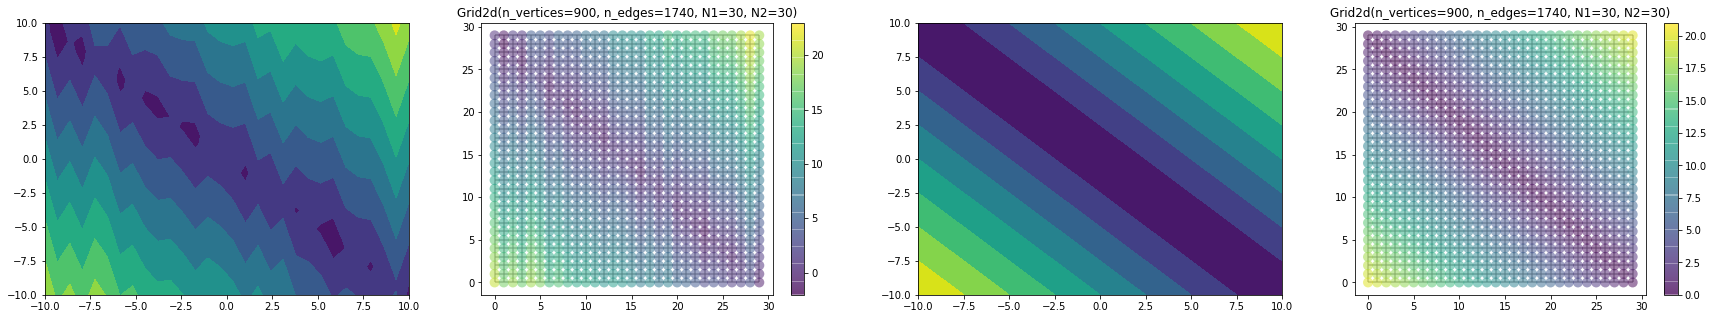

In [34]:
fig, (ax_0, ax_1, ax_2, ax_3) = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))

graph_size = 30
g, coords =get_grid_graph(graph_size,graph_size)
x = np.linspace(-10, 10, graph_size)
y = np.linspace(-10, 10, graph_size)
w = np.linspace(-10,10, graph_size**2)
xx, yy = np.meshgrid(x, y, sparse=True)

z_sin = np.tan(w)
z_orig =  np.abs(xx+yy)

z_bruit = z_orig + np.random.normal(size=graph_size, loc = 0, scale =1)
    

ax_0.contourf(x, y, z_bruit)
g.plot_signal(z_bruit.flatten(), ax=ax_1)
ax_2.contourf(x, y, z_orig)
g.plot_signal(z_orig.flatten(), ax=ax_3 )


plt.show()



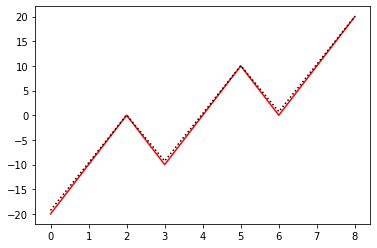

In [19]:
plt.plot(z_orig.flatten(),'r')
plt.plot(z_bruit.flatten(), "k:")

In [35]:


Y = z_orig.flatten()
n = Y.size


adj_mat = g.W.toarray()
nb_edges = int(count_one(adj_mat)/2)

delta1 = inc_to_delta(adj_mat)

D = np.array(GDO(delta1, 2))



vlambda = 50
# Solve l1 trend filtering problem.
X = cp.Variable(shape=(n,))




obj = cp.Minimize(0.5 * cp.norm(Y - X,2)**2 
                  + vlambda * cp.norm(D@X, 1) )
prob = cp.Problem(obj)
# ECOS and SCS solvers fail to converge before
# the iteration limit. Use CVXOPT instead.
prob.solve(solver=cp.CVXOPT, verbose=False)
#print(x.value)
#print(loss_function(z.flatten(),X.value))

3883.9942347465094

In [39]:
#print(GDO2(delta1, 2) )
oui = sec_diff(X.value, g.W.toarray())
print(sec_diff(X.value, g.W.toarray()))
ax3d = plt.axes(projection='3d')
ax3d.plot_trisurf(coords[:,0], coords[0:,1] ,X.value, cmap=plt.cm.Spectral)

#ax3d.scatter(coords[:,0], coords[0:,1] ,X.value,s=5)
plt.show()


diff = np.dot(D,X.value)


binar_graph = []
highlight = []



color=[]

#for i in range(len(diff)):
#    itsok2.append(diff[itsok[i]-1])
for i in range(len(oui)):
    if np.abs(oui[i]) >= 1e-4:
        highlight.append(i)
        
diff = oui
for i in range(len(diff)):

    if np.abs(diff[i]) < 1e-4:
        
        diff[i] = 0
        binar_graph.append(0)
        color.append((0,0,0,0.1))
    else:
        binar_graph.append(1)
        color.append((1,0,0,1))

        
    

plt.plot(diff, "*-")

all_color = ['blue', 'red', 'yellow', 'black', 'grey', 'white', 'aqua', 'green', 'brown', 'pink', 'purple', 'orange']

g.plot_signal(X.value, indices = False, highlight = highlight, edge_color = color)
plt.show()
plt.plot(X.value)



ZeroDivisionError: division by zero

In [328]:
Y = z_bruit.flatten()
n = Y.size


adj_mat = g.W.toarray()

delta1 = inc_to_delta(adj_mat)

D = np.array(GDO(delta1, 2))

error = []
lambdamax = lambda_max(Y, delta1, 2)
print(lambdamax)
lambda_list = np.linspace(1, int( lambdamax), 50)
for mylambda in lambda_list:
    print(mylambda)
   
    
   


    
# Solve l1 trend filtering problem.
    X = cp.Variable(shape=(n,))




    obj = cp.Minimize(0.5 * cp.norm(Y - X,2)**2 
                  + mylambda * cp.norm(D@X, 1) )
    prob = cp.Problem(obj)
# ECOS and SCS solvers fail to converge before
# the iteration limit. Use CVXOPT instead.
    prob.solve(solver=cp.CVXOPT, verbose=False)
    error.append(loss_function(Y, X.value))
    

oui100
size = 180
cc
cc2
8.457901438012343e+17
1.0
1.7261023342882332e+16


SolverError: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information.

Text(0, 0.5, 'Error')

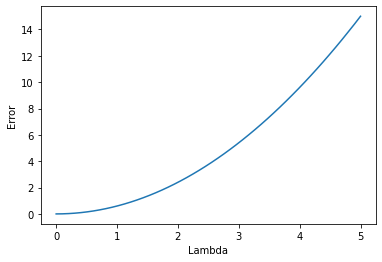

In [247]:
plt.plot(lambda_list, error)
plt.xlabel("Lambda")
plt.ylabel("Error")

In [197]:
import matplotlib.pyplot as plt
idx = np.argmax(np.abs(graph.U))
idx_vertex, idx_fourier = np.unravel_index(idx, graph.U.shape)
_ = graph.plot(graph.U[:, idx_fourier], highlight=idx_vertex)

NameError: name 'graph' is not defined